In [86]:
def showRender():
    img = plt.imshow(env.render(mode='rgb_array')) # only call this once
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [87]:
import gym
from gym.core import Wrapper
# from _pickle import dumps, loads
from collections import namedtuple
import math
import time
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

class withSnapshot(Wrapper):
    
    def getSnapshot(self):
        return self.env.ale.cloneState()
    
    def loadSnapshot(self,snapshot):
        self.env.ale.restoreState(snapshot)
        
#     def getResult(self,snapshot,action):
        
#         self.loadSnapshot(snapshot)
#         _,reward,done,_=self.env.step(action)
#         new_snapshot=self.getSnapshot()
        
#         return new_snapshot,reward,done

#### Here is the game
each step given by MCTS, reward will be returned and root's snapshot will be changed

In [231]:
class Node:
    
    def __init__(self,parent,action):
        self.n=0
        self.t=0
        self.parent=parent
        self.children=[]
        self.action=action
        
        # modified for root node
        if action!=None:
            env.loadSnapshot(self.parent.snapshot)
            env.step(action)
            self.snapshot=env.getSnapshot()
        else:
            env.reset()
            env.seed(1995)
            self.snapshot=env.getSnapshot()
    
    def ucb(self):
        if self.n==0:
            return 10086
        else:
            scalar=1/math.sqrt(2)
            return self.t/self.n+2*scalar*math.sqrt(self.parent.n/self.n)
            
    def is_leaf(self):
        return len(self.children)==0
    
    def select_best_leaf(self):
        if self.is_leaf():
            return self
        
        ucbVal=[]
        for i in self.children:
            ucbVal.append(i.ucb())
            
        best_leaf=self.children[ucbVal.index(max(ucbVal))]
        return best_leaf.select_best_leaf()
    
    def expand(self):
        action_space=4
        
        for i in range(action_space):
            self.children.append(Node(self,i))
            
        return self.select_best_leaf()
    
    def propagate(self,value):
        
#         my_value=self.t+value
#         print('Now {} is added to {}'.format(my_value,self.action))
        self.t+=value
        self.n+=1
        
        if self.parent!=None:
            return self.parent.propagate(value)
        

In [247]:
def rollout(node):
    
    env.loadSnapshot(node.snapshot)
    
    rollout_done=False
    endReward=0
    last=0
    
    while True:
        action = env.action_space.sample()
        _, immediate_reward, rollout_done, _ = env.step(action)
        endReward+=immediate_reward
        last+=1
        if rollout_done:
            break
            
    print("rollout:",last)
#     print('\nrollout time: {}  endReward: {}'.format(end-start,endReward))
    node.propagate(endReward)
    return endReward
        

#### Main part of the MCTS algo

In [244]:
def MCTS(node):
    #node is the current root
    
    for i in range(15):
#         print("|",end='')

        if node.is_leaf():  # specific for root node
            
            if node.n>0:
                node.expand()
                reward=rollout(node.children[0])
            if node.n==0:
                reward=rollout(node)

        else:
            
            leaf=node.select_best_leaf() # then leaf and select_return have same id
            
            if leaf.n==0:
                print('rollout2')
                env.loadSnapshot(leaf.snapshot)
                reward=rollout(leaf)
            elif leaf.n>0 and leaf.children==[]:
                new_leaf=leaf.expand()
                print('rollout3')
                env.loadSnapshot(new_leaf.snapshot)
                reward=rollout(new_leaf)

    val=[]
    for i in node.children:
        val.append(i.t)
            
    ###########Monitor###########
    print(val)
    
    return node.children[val.index(max(val))],node.children[val.index(max(val))].action

In [248]:
env=withSnapshot(gym.make("Breakout-v4"))
test=Node(None,None)
# t=rollout(test)
# showRender()

In [249]:
done = False
acList=[]
for i in range(10000):
    
    new_root,action=MCTS(test)
    env.loadSnapshot(test.snapshot)
    _,reward,done,_=env.step(action)
    acList.append(action)
    test.snapshot=env.getSnapshot()
    test.n,test.t=0,0
    test.child=[]
#     print('reward:{} action:{}\n is_done:{}'.format(reward,action,done))
    print(done)
    if done:
        break
    

rollout: 235
rollout: 200
rollout2
rollout: 293
rollout2
rollout: 158
rollout2
rollout: 305
rollout3
rollout: 170
rollout3
rollout: 171
rollout3
rollout: 180
rollout3
rollout: 234
rollout2
rollout: 163
[1.0, 2.0, 1.0, 2.0]
False
rollout2
rollout: 282
rollout2
rollout: 190
rollout2
rollout: 219
rollout2
rollout: 299
rollout2
rollout: 185
rollout2
rollout: 381
rollout2
rollout: 174
rollout2
rollout: 309
rollout3
rollout: 182
rollout2
rollout: 379
[8.0, 2.0, 8.0, 5.0]
False
rollout3
rollout: 285
rollout3
rollout: 168
rollout2
rollout: 228
rollout2
rollout: 507
rollout2
rollout: 277
rollout3
rollout: 261
rollout2
rollout: 244
rollout3
rollout: 292
rollout2
rollout: 174
rollout3
rollout: 249
[24.0, 2.0, 9.0, 5.0]
False
rollout3
rollout: 226
rollout3
rollout: 213
rollout2
rollout: 164
rollout2
rollout: 304
rollout2
rollout: 230
rollout3
rollout: 170
rollout2
rollout: 341
rollout2
rollout: 335
rollout2
rollout: 264
rollout3
rollout: 285
[35.0, 2.0, 12.0, 5.0]
False
rollout3
rollout: 168
rollo

False


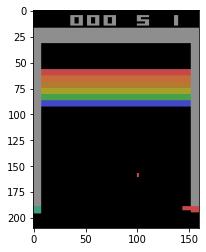

In [230]:
env.loadSnapshot(new_root.snapshot)
showRender()
for i in range(10):
    _,_,done,_=env.step(1)
print(done)

#### Kernel test:

In [120]:
print(done)

True


#### Visualization

In [225]:
print(acList)

[2, 2, 3, 3, 3, 1, 2, 0, 2, 0, 0, 2, 0, 1, 2, 2, 2, 2, 3, 0, 1, 2, 0, 2, 0, 0, 2, 1, 0, 3, 0, 2, 2, 1, 3, 0]


[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False

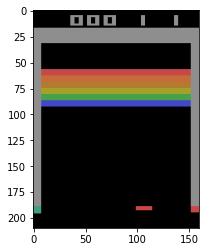

In [235]:
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
doneList=[]
for i in range(10000):
    _,_,done,_=env.step(1)
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    doneList.append(done)
    if done:
        break

print(doneList)

In [131]:
env.getSnapshot()==new_root.snapshot

False